In [1]:
import pickle
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt
from traoptlibrary.traopt_utilis import rotm2euler
from traoptlibrary.traopt_dynamics import Pendulum3dDyanmics
from traoptlibrary.traopt_cost import SO3TrackingQuadraticGaussNewtonCost
from traoptlibrary.traopt_controller import iLQR_Tracking_SO3_MS, iLQR_Tracking_SO3
from traoptlibrary.traopt_baseline import EmbeddedEuclideanSO3_Pendulum3D, EmbeddedEuclideanSO3,\
                                        EmbeddedEuclideanSO3_MatrixNorm, EmbeddedEuclideanSO3_Pendulum3D_MatrixNorm
from scipy.spatial.transform import Rotation
from manifpy import SO3, SO3Tangent

SAVE_RESULTS = False
SAVE_RESULTS_DIR = 'visualization/results_benchmark/results_pendulum_swingup_benchmark.pkl'

# =====================================================
# Iteration Function
# =====================================================

def on_iteration_ms_so3(iteration_count, xs, us, J_opt, accepted, 
                converged, defect_norm, grad_wrt_input_norm,
                alpha, mu, J_hist, xs_hist, us_hist, grad_hist, defect_hist):
    J_hist.append(J_opt)
    xs_hist.append(xs.copy())
    us_hist.append(us.copy())
    grad_hist.append(grad_wrt_input_norm.copy())
    defect_hist.append( defect_norm )

    info = "converged" if converged else ("accepted" if accepted else "failed")
    print("Iteration", iteration_count, \
          info, J_opt, defect_norm, \
          grad_wrt_input_norm, alpha, mu)
    
def on_iteration_ss_so3(iteration_count, xs, us, J_opt, accepted, converged,grad_wrt_input_norm,
                  alpha, mu, J_hist, xs_hist, us_hist):
    J_hist.append(J_opt)
    xs_hist.append(xs.copy())
    us_hist.append(us.copy())
    info = "converged" if converged else ("accepted" if accepted else "failed")
    print("Iteration", iteration_count, info, J_opt, grad_wrt_input_norm, alpha, mu)

# =====================================================
# Problem Import: Reference, Initial State, Solver Options
# =====================================================

path_to_reference_file = \
    'visualization/optimized_trajectories/path_3dpendulum_swingup.npy'
    # 'visualization/optimized_trajectories/path_3dpendulum_8shape.npy'
    
with open( path_to_reference_file, 'rb' ) as f:
    q_ref = np.load(f)
    xi_ref = np.load(f)
    dt = np.load(f)

Nsim = q_ref.shape[0] - 1
print("Horizon of dataset is", Nsim)

q0 = SO3( Rotation.from_euler('xy',[10., 45.], degrees=True).as_quat() ) 
# xi0 = SO3Tangent( np.array([1.,1.,0.]) * 5 )
xi0 = SO3Tangent( np.array([1.,1.,0.]) * 3 )
x0_mnf = [ q0, xi0 ]
x0_np = [ q0.rotation(), xi0.coeffs() ]

J = np.diag([ 0.5,0.7,0.9 ])
m = 1
length = 0.5

max_iterations = 2000

tol_gradiant_converge = 1e-12
tol_converge = tol_gradiant_converge

# =====================================================
# Helper Function
# =====================================================

def err_dyn(xk, xk1, dt=dt):
    Xk, wk = xk
    Xk1, _ = xk1
    
    Xk_mnf = SO3( Rotation.from_matrix(Xk).as_quat() )
    wk_mnf = SO3Tangent( wk )
    Xk_sim = Xk_mnf.rplus( wk_mnf * dt ).rotation()

    return np.linalg.norm(Xk_sim - Xk1)

# =====================================================
# Algorithms on Matrix Lie Groups: Dynamics, Cost, Controller
# =====================================================

N = Nsim # horizon, note the state length = horizon + 1
HESSIANS = False
action_size = 3
state_size = 6

dynamics = Pendulum3dDyanmics(J, m, length, dt, hessians=HESSIANS)

Q = np.diag([ 
    10., 10., 10., 1., 1., 1.,
])
P = Q * 10
R = np.identity(3) * 1e-2
cost = SO3TrackingQuadraticGaussNewtonCost( Q, R, P, q_ref, xi_ref )

us_init = np.zeros((N, action_size,))

ilqr_ms_so3 = iLQR_Tracking_SO3_MS( dynamics, cost, N, 
                                    q_ref, xi_ref,
                                    hessians=HESSIANS,
                                    line_search=False,
                                    rollout='nonlinear' )

ilqr_ss_so3 = iLQR_Tracking_SO3(    dynamics, cost, N, 
                                    hessians=HESSIANS,
                                    rollout='nonlinear' )

xs_ms_so3, us_ms_so3, J_hist_ms_so3, _, _, \
    grad_hist_ms_so3, defect_hist_ms_so3= \
        ilqr_ms_so3.fit(x0_mnf, us_init, 
                        n_iterations=max_iterations, 
                        tol_grad_norm=tol_gradiant_converge,
                        on_iteration=on_iteration_ms_so3)
xs_ms_so3 = [ [x[0].rotation(), x[1].coeffs() ] for x in xs_ms_so3 ]

# xs_ss_so3, us_ss_so3, J_hist_ss_so3, _, _, grad_hist_ss_so3 = \
#         ilqr_ss_so3.fit(x0_mnf, us_init, 
#                         n_iterations=max_iterations, 
#                         tol_grad_norm=tol_gradiant_converge,
#                         on_iteration=on_iteration_ss_so3)
# xs_ss_so3 = [ [x[0].rotation(), x[1].coeffs() ] for x in xs_ss_so3 ]


# =====================================================
# Embedded Space Method
# =====================================================
eps_init = 5*1e0

# intialize the embedded method
# ipopt_unconstr_euc = EmbeddedEuclideanSO3_Pendulum3D( q_ref, xi_ref, dt, J, m, 
#                                                      length, Q, R, eps_init )
ipopt_unconstr_euc = EmbeddedEuclideanSO3_Pendulum3D_MatrixNorm(  q_ref, xi_ref, dt, J, m, 
                                                                  length, Q, R, eps_init )
# ipopt_unconstr_euc = EmbeddedEuclideanSO3( q_ref, xi_ref, dt, J, Q, R )
# ipopt_unconstr_euc = EmbeddedEuclideanSO3_MatrixNorm( q_ref, xi_ref, dt, J, Q, R )

# get the solution
xs_unconstr_euc, us_unconstr_euc, J_hist_unconstr_euc, \
    grad_hist_unconstr_euc, defect_hist_unconstr_euc = \
        ipopt_unconstr_euc.fit( x0_np, us_init, 
                                n_iterations=max_iterations,
                                tol_norm=tol_converge )

Horizon of dataset is 80
Start Iteration: 0 , Used Time: 8.140800127875991e-05
Iteration: 0 Linearization Finished, Used Time: 0.025386663000972476 Cost: 106.82636956722138 DefectNorm: 5.0996011917437505
Iteration: 0 Gradient w.r.t. input: 0.021597259147761956
Iteration: 0 Backward Pass Finished, Used Time: 0.031805038001039065
Iteration: 0 Forward Rollout Finished, Used Time: 0.046393206001084764 Alpha: 1 Cost: 88102.77483141037
Iteration 0 accepted 88102.77483141037 1.8639198115107546e-16 0.021597259147761956 1 0.0
Start Iteration: 1 , Used Time: 0.046496824999849196
Iteration: 1 Linearization Finished, Used Time: 0.06917757300107041 Cost: 88102.77483141037 DefectNorm: 1.8639198115107546e-16
Iteration: 1 Gradient w.r.t. input: 5.193181842830585
Iteration: 1 Backward Pass Finished, Used Time: 0.07611652200102981
Iteration: 1 Forward Rollout Finished, Used Time: 0.09201122400008899 Alpha: 1 Cost: 36557.3824610897
Iteration 1 accepted 36557.3824610897 1.9502239443311997e-14 5.1931818428

In [2]:
X = x0_mnf[0]
xi = x0_mnf[1]

list_X = []
list_X.append(X.rotation().copy())

for i in range( int(Nsim/5.) ):
    X = X.rplus(xi*dt)
    list_X.append(X.rotation().copy())

pendulum_length = 1.2
updown_vector = np.array([0., 0., -pendulum_length]).reshape(3,1)
pos_rod_fw_sim = np.array([x @ updown_vector for x in list_X])

Text(0.5, 0.5, 'y')

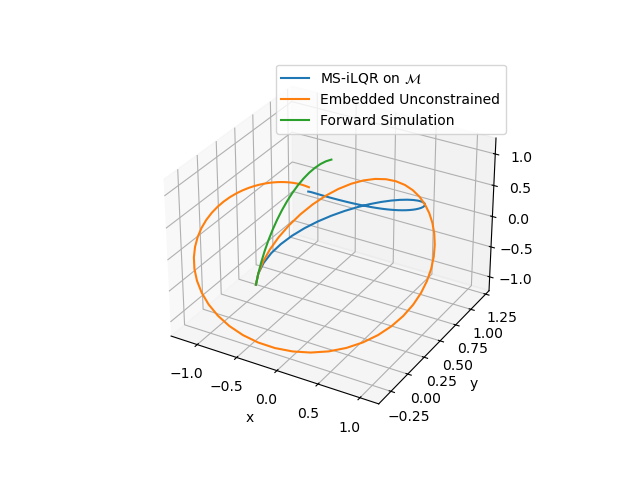

In [5]:
%matplotlib widget
pendulum_length = 1.2
updown_vector = np.array([0., 0., -pendulum_length]).reshape(3,1)

pos_rod_ms_so3 = np.array([x[0] @ updown_vector for x in xs_ms_so3]).reshape(N+1, 3)
pos_rod_unconstr_euc = np.array([x[0] @ updown_vector for x in xs_unconstr_euc]).reshape(N+1, 3)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(pos_rod_ms_so3[:, 0], pos_rod_ms_so3[:, 1], pos_rod_ms_so3[:, 2],
            label=r'MS-iLQR on $\mathcal{M}$')
ax.plot(pos_rod_unconstr_euc[:, 0], pos_rod_unconstr_euc[:, 1], pos_rod_unconstr_euc[:, 2],
            label='Embedded Unconstrained')
ax.plot(pos_rod_fw_sim[:, 0], pos_rod_fw_sim[:, 1], pos_rod_fw_sim[:, 2],
            label='Forward Simulation')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')

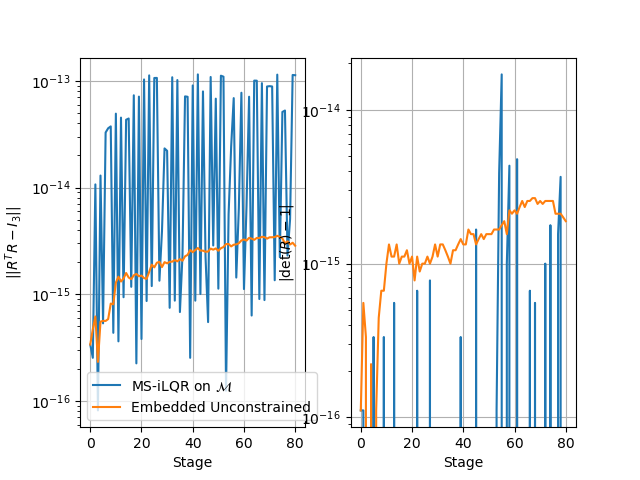

In [4]:
violation_orth_ms_so3 = [ np.linalg.norm(x[0].T @ x[0] - np.identity(3)) for x in xs_ms_so3 ]
# violation_orth_ss_so3 = [ np.linalg.norm(x[0].T @ x[0] - np.identity(3)) for x in xs_ss_so3 ]
violation_orth_unconstr_euc = [ np.linalg.norm(x[0].T @ x[0] - np.identity(3)) for x in xs_unconstr_euc ]
# violation_orth_constr_euc = [ np.linalg.norm(x[0].T @ x[0] - np.identity(3)) for x in xs_constr_euc ]

violation_det_ms_so3 = [ 1 - np.linalg.det(x[0]) for x in xs_ms_so3 ]
# violation_det_ss_so3 = [ 1 - np.linalg.det(x[0]) for x in xs_ss_so3 ]
violation_det_unconstr_euc = [ 1 - np.linalg.det(x[0]) for x in xs_unconstr_euc ]
# violation_det_constr_euc  = [ 1 - np.linalg.det(x[0]) for x in xs_constr_euc ]

plt.figure()
ax = plt.subplot(121)
plt.plot( violation_orth_ms_so3, label=r'MS-iLQR on $\mathcal{M}$' )
# plt.plot( violation_orth_ss_so3, label=r'SS-iLQR on $\mathcal{M}$' )
plt.plot( violation_orth_unconstr_euc, label='Embedded Unconstrained' )
# plt.plot( violation_orth_constr_euc, label='Embedded Stabilization' )
plt.yscale('log')
plt.ylabel(r'$||R^T R - I_3||$')
plt.xlabel('Stage')
plt.legend()
plt.grid()

ax = plt.subplot(122)
plt.plot( violation_det_ms_so3, label=r'MS-iLQR on $\mathcal{M}$' )
# plt.plot( violation_det_ss_so3, label=r'SS-iLQR on $\mathcal{M}$' )
plt.plot( violation_det_unconstr_euc, label='Embedded Unconstrained' )
# plt.plot( violation_det_constr_euc, label='Embedded Stabilization' )
plt.yscale('log')
plt.ylabel(r'$|\text{det}(R)-1|$')
plt.xlabel('Stage')
plt.grid()

## DRONE

In [1]:
import pickle
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt
from traoptlibrary.traopt_utilis import rotm2euler, SE32manifSE3, se32manifse3, manifSE32SE3
from traoptlibrary.traopt_dynamics import DroneDynamics
from traoptlibrary.traopt_cost import SE3TrackingQuadraticGaussNewtonCost
from traoptlibrary.traopt_controller import iLQR_Tracking_SE3_MS, iLQR_Tracking_SE3
from traoptlibrary.traopt_baseline import EmbeddedEuclideanSE3_Drone, EmbeddedEuclideanSE3_Drone_MatrixNorm
from scipy.spatial.transform import Rotation
from manifpy import SE3, SE3Tangent

SAVE_RESULTS = True
SAVE_RESULTS_DIR = 'visualization/results_benchmark/results_drone_racing_tracking_benchmark.pkl'

# =====================================================
# Iteration Function
# =====================================================

def on_iteration_ms_se3(iteration_count, xs, us, J_opt, accepted, 
                converged, defect_norm, grad_wrt_input_norm,
                alpha, mu, J_hist, xs_hist, us_hist, grad_hist, defect_hist):
    J_hist.append(J_opt)
    xs_hist.append(xs.copy())
    us_hist.append(us.copy())
    grad_hist.append(grad_wrt_input_norm.copy())
    defect_hist.append( defect_norm )

    info = "converged" if converged else ("accepted" if accepted else "failed")
    print("Iteration", iteration_count, \
          info, J_opt, defect_norm, \
          grad_wrt_input_norm, alpha, mu)
    
def on_iteration_ss_se3(iteration_count, xs, us, J_opt, accepted, converged,grad_wrt_input_norm,
                  alpha, mu, J_hist, xs_hist, us_hist):
    J_hist.append(J_opt)
    xs_hist.append(xs.copy())
    us_hist.append(us.copy())
    info = "converged" if converged else ("accepted" if accepted else "failed")
    print("Iteration", iteration_count, info, J_opt, grad_wrt_input_norm, alpha, mu)

# =====================================================
# Problem Import: Reference, Initial State, Solver Options
# =====================================================

dt = 0.004

path_to_reference_file = \
    'visualization/optimized_trajectories/path_dense_random_columns_4obj.npy'

with open( path_to_reference_file, 'rb' ) as f:
    q_ref = np.load(f)
    xi_ref = np.load(f)

Nsim = q_ref.shape[0] - 1
# Nsim = 300
# q_ref = q_ref[:Nsim+1]
# xi_ref = xi_ref[:Nsim+1]

print("Horizon of dataset is", Nsim)

q0 = SE3(
    position = -1 * np.ones((3,)) + q_ref[0][:3,3],
    quaternion = Rotation.from_euler('zxy', [90.,10.,45.], degrees=True).as_quat() 
).transform()
xi0 = np.ones((6,)) * 1e-1
x0 = [ q0, xi0 ]

m = 1
Ib = np.diag([ 0.5,0.7,0.9 ])
J = np.block([
    [Ib, np.zeros((3, 3))],
    [np.zeros((3, 3)), m * np.identity(3)]
])

max_iterations = 200

tol_gradiant_converge = 1e-12
tol_converge = tol_gradiant_converge

# =====================================================
# Helper Function
# =====================================================

def err_dyn(xk, xk1, dt=dt):
    Xk, wk = xk
    Xk1, _ = xk1
    
    Xk_mnf = SE32manifSE3(Xk)
    wk_mnf = se32manifse3(wk)  
    Xk_sim = Xk_mnf.rplus( wk_mnf * dt ).transform()

    return np.linalg.norm(Xk_sim - Xk1)


# =====================================================
# Algorithms on Matrix Lie Groups: Dynamics, Cost, Controller
# =====================================================

N = Nsim
HESSIANS = False
action_size = 4
state_size = 12

dynamics = DroneDynamics( J, dt, hessians=HESSIANS )

Q = np.diag([ 
    25., 25., 25., 10., 10., 10.,
    1., 1., 1., 1., 1., 1. 
]) 
P = Q * 10
R = np.identity(action_size) * 1e-3
cost = SE3TrackingQuadraticGaussNewtonCost( Q, R, P, q_ref, xi_ref, action_size=4)

us_init = np.zeros((N, action_size,))

ilqr_ms_se3 = iLQR_Tracking_SE3_MS( dynamics, cost, N, 
                                    q_ref, xi_ref,
                                    hessians=HESSIANS,
                                    line_search=False,   
                                    rollout='nonlinear' )

ilqr_ss_se3 = iLQR_Tracking_SE3(    dynamics, cost, N, 
                                    hessians=HESSIANS,
                                    rollout='nonlinear' )

# xs_ms_se3, us_ms_se3, J_hist_ms_se3, _, _, \
#     grad_hist_ms_se3, defect_hist_ms_se3= \
#         ilqr_ms_se3.fit(x0, us_init, 
#                         n_iterations=max_iterations, 
#                         tol_grad_norm=tol_gradiant_converge,
#                         on_iteration=on_iteration_ms_se3)

# xs_ss_se3, us_ss_se3, J_hist_ss_se3, _, _, grad_hist_ss_se3 = \
#         ilqr_ss_se3.fit(x0, us_init, 
#                         n_iterations=max_iterations, 
#                         tol_grad_norm=tol_gradiant_converge,
#                         on_iteration=on_iteration_ss_se3)

# =====================================================
# Embedded Euclidean Unconstrained Method
# =====================================================
eps_init = 1e-3

# # intialize the embedded method
ipopt_logcost_euc = EmbeddedEuclideanSE3_Drone( q_ref, xi_ref, dt, J, Q, R, 
                                                eps_init=eps_init )

# get the solution
xs_logcost_euc, us_logcost_euc, J_hist_logcost_euc, \
    grad_hist_logcost_euc, defect_hist_logcost_euc = \
        ipopt_logcost_euc.fit(   x0, us_init, 
                                n_iterations=max_iterations,
                                tol_norm=tol_converge )

Horizon of dataset is 955

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   248322
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   172954

Total number of variables............................:    24852
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:    21032
To

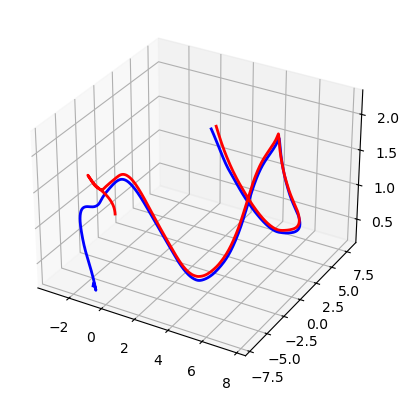

In [5]:
q_xyz_ilqr = np.array([ x[0][:3,3] for x in xs_logcost_euc ] )
q_xyz_ref = np.array([ x[:3,3] for x in q_ref ] )

fig1 = plt.figure()
ax1 = fig1.add_subplot(111, projection='3d')
ax1.plot(   q_xyz_ilqr[:, 0], q_xyz_ilqr[:, 1], q_xyz_ilqr[:, 2],
            label='Final Trajectory', color='blue', linewidth=2)
ax1.plot(   q_xyz_ref[:, 0], q_xyz_ref[:, 1], q_xyz_ref[:, 2],
            label='Reference Trajectory', color='red', linewidth=2)

In [12]:
us_logcost_euc

array([[-550.07367895, -653.82967447, -869.12764298,  178.59884499],
       [-460.4902528 , -560.47229566, -681.38206549,  155.82317913],
       [-377.26389266, -458.47344608, -521.00764115,  120.52590158],
       ...,
       [ 136.99768875,  236.00115942,   10.53501099,    7.10347965],
       [ 152.98847455,  256.8318788 ,    9.67132097,    8.61574239],
       [ 155.89812672,  256.70966521,    8.51917254,    9.51538398]])

In [15]:
q_logcost_euc = np.array([x[0] for x in xs_logcost_euc])
xi_logcost_euc = np.array([x[1] for x in xs_logcost_euc])

with open('temp.npy', 'wb') as f:
    np.save(f, q_logcost_euc)
    np.save(f, xi_logcost_euc)
    np.save(f, us_logcost_euc)

In [6]:
us_logcost_euc

array([[-550.07367895, -653.82967447, -869.12764298,  178.59884499],
       [-460.4902528 , -560.47229566, -681.38206549,  155.82317913],
       [-377.26389266, -458.47344608, -521.00764115,  120.52590158],
       ...,
       [ 136.99768875,  236.00115942,   10.53501099,    7.10347965],
       [ 152.98847455,  256.8318788 ,    9.67132097,    8.61574239],
       [ 155.89812672,  256.70966521,    8.51917254,    9.51538398]])